In [37]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import gc

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import keras
import swifter

from keras import Model
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau

from sklearn.metrics.pairwise import pairwise_distances

warnings.filterwarnings('ignore')

### Define functions for use throughout notebook

In [38]:

#confusion matrix to test model predictions on validation dataset
def plot_confusion_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred,axis = 1) 
    y_test_classes = np.argmax(y_test, axis = 1)
    cm = confusion_matrix(y_test_classes, y_pred_classes) 
    sns.heatmap(cm, annot = True,fmt='.0f')
    plt.show()

In [39]:
#load images to an array for faster processing
def load_images(names, articletype):
    image_array = []
    for image_name in tqdm(names, desc = 'reading images for ' + articletype):
        img_path = IMAGE_PATH + image_name
        try:
            img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        except:
            continue
        img = image.img_to_array(img)
        image_array.append(img)
    return np.array(image_array)

In [40]:
#define similarity score logic
def get_recommender(idx, df, top_n = 5):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_similarity[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim

### Data Exploration

In [41]:
DATA_PATH = '/users/caroline.hughes/anaconda3/envs/py38_env/product_labeling/product_labeling/'
IMAGE_PATH = DATA_PATH + 'images/'
IMAGE_SIZE = 224
LIMIT_IMAGES = 1000

In [42]:
dfstyles = pd.read_csv(DATA_PATH + 'styles.csv', error_bad_lines=False, warn_bad_lines=False)
#merge images with styles data
dfstyles['image'] = dfstyles['id'].map(lambda x: str(x) + '.jpg')
dfstyles.columns = dfstyles.columns.str.lower()
print(dfstyles.shape)
dfstyles.head()

(44424, 11)


,id,gender,mastercategory,subcategory,articletype,basecolour,season,year,usage,productdisplayname,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg


In [43]:
dfstyles['articletype'].nunique()

143

In [44]:
dfstyles['articletype'].value_counts().head()

Tshirts         7067
Shirts          3217
Casual Shoes    2845
Watches         2542
Sports Shoes    2036
Name: articletype, dtype: int64

In [45]:
dfstyles['cntarticle'] = dfstyles.groupby('articletype')['id'].transform('count')
dfdata = dfstyles[dfstyles['cntarticle'] > 500]
print(dfdata.shape, dfdata['articletype'].nunique())

(34223, 12) 22


In [46]:
dfarticles =dfdata.groupby('articletype',as_index=False)['id'].count()
dfarticles

,articletype,id
0,Backpacks,724
1,Belts,813
2,Briefs,849
3,Casual Shoes,2845
4,Flip Flops,914
5,Formal Shoes,637
6,Handbags,1759
7,Heels,1323
8,Jeans,609
9,Kurtas,1844


### Preview Images

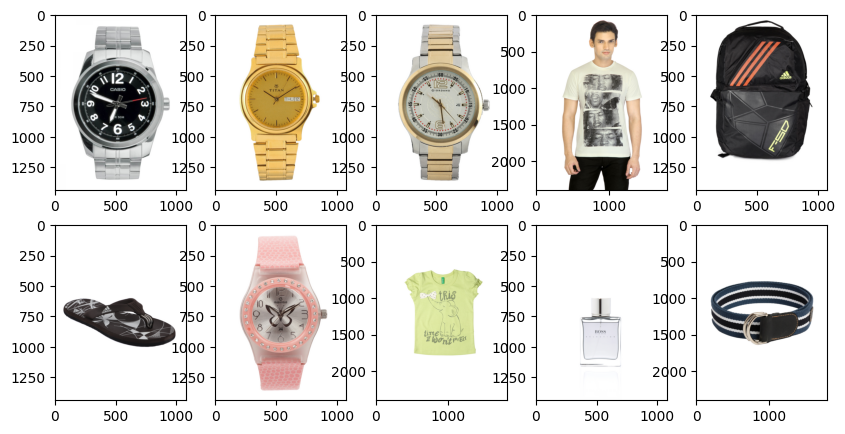

In [47]:
imglist = [IMAGE_PATH + x for x in dfdata['image'].sample(10).values]

fig,ax = plt.subplots(2,5,figsize=(10,5))
for index, img_file in enumerate(imglist):
    img = plt.imread(img_file)
    x = int(index / 5)
    y = index % 5
    ax[x,y].imshow(img)
plt.show()  

### Create separate lists for images and article labels

In [48]:
##pull out sample of articles for training- backpacks, belts, briefs, and casual shoes
image_list = []
article_list = []
for index, grouprow in dfarticles.iterrows():
    if index > 4:
        continue
    image_names = dfdata[dfdata['articletype'] == grouprow['articletype']]['image'].values
    if len(image_names) > LIMIT_IMAGES:
        image_names = image_names[:LIMIT_IMAGES]
    image_list.extend(load_images(image_names, grouprow['articletype']))
    article_list.extend(len(image_names) * [grouprow['articletype']])

image_list

reading images for Flip Flops: 100%|██████████| 914/914 [00:11<00:00, 82.87it/s] 


[array([[[254., 254., 254.],
         [254., 254., 254.],
         [254., 254., 254.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],
 
        [[254., 254., 254.],
         [254., 254., 254.],
         [255., 255., 255.],
         ...,
         [254., 254., 254.],
         [254., 254., 254.],
         [254., 254., 254.]],
 
        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [254., 254., 254.],
         [254., 254., 254.],
         [254., 254., 254.]],
 
        ...,
 
        [[254., 254., 254.],
         [254., 254., 254.],
         [254., 254., 254.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],
 
        [[254., 254., 254.],
         [254., 254., 254.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],
 
        [[254., 254., 254.],
 

### Preprocessing

In [49]:
#each image pixel has a grayscale integer value between 0-255; normalizing values to produce float value b.w 0-1
X= np.array(image_list) / 255.0
X = X.reshape(-1,IMAGE_SIZE,IMAGE_SIZE,3)
y_encoded = LabelEncoder().fit_transform(article_list)
print("Number of classes : ",np.unique(y_encoded, return_counts=True))
y = to_categorical(y_encoded, num_classes = len(np.unique(article_list)))
print(y[:5])

Number of classes :  (array([0, 1, 2, 3, 4]), array([ 724,  813,  849, 1000,  914]))
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
print(X_train.shape, X_test.shape)

(3870, 224, 224, 3) (430, 224, 224, 3)


### Define Model

In [51]:
#using sequential keras model in order to sequentially add layers to the model
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (224,224,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(len(np.unique(article_list)), activation = "softmax"))
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 224, 224, 32)      2432      
                                                                 
 conv2d_9 (Conv2D)           (None, 224, 224, 32)      25632     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 112, 112, 32)      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 112, 112, 64)      36928     
                                                      

In [52]:
del X,y,article_list,image_list
gc.collect()

31098

In [53]:
# Implement RMSprop algorithm; RMSprop = maintains a moving average of the square of gradient and divides the gradient by the root of this average
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08)

In [54]:
#Using this crossentropy loss function when there are two or more label classes
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [55]:
# Reduce learning rate when a metric has stopped improving
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


In [56]:
EPOCHS = 3
BATCH_SIZE = 64


### Fit Model

In [59]:
history = model.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_test, y_test), verbose = 2
                   , callbacks=[learning_rate_reduction])

Epoch 1/3
61/61 - 275s - loss: 6.3467 - accuracy: 0.6633 - val_loss: 0.1473 - val_accuracy: 0.9488 - lr: 0.0010 - 275s/epoch - 5s/step
Epoch 2/3
61/61 - 271s - loss: 1.0428 - accuracy: 0.8558 - val_loss: 0.7560 - val_accuracy: 0.7698 - lr: 0.0010 - 271s/epoch - 4s/step
Epoch 3/3
61/61 - 272s - loss: 0.4059 - accuracy: 0.8845 - val_loss: 0.1770 - val_accuracy: 0.9302 - lr: 0.0010 - 272s/epoch - 4s/step


### Model accuracy on validation data

In [60]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_test_classes = np.argmax(y_test, axis = 1)

14/14 [==============================] - 7s 513ms/step


In [61]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred_classes, y_test_classes)

0.9302325581395349

14/14 [==============================] - 7s 477ms/step


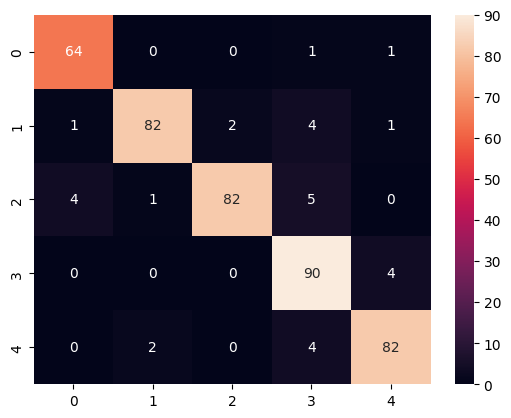

In [62]:
plot_confusion_matrix(model, X_test, y_test)